<a href="https://colab.research.google.com/github/jackson-the-great/Collab-Game/blob/main/Stock_Prediction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock price prediction using LSTM neural network and Tensorflow**
What do we need here:

- Load data
- Scale data for machine learning model
- Setup neural network
- Compile model
- Teach neural network and fit this
- Use the model for prediction
- Draw the results chart

In [ ]:
!pip install LSTM # requirement

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
company = 'UBER'
stock_data = pd.read_csv("sample_data/UBER_stock.csv", parse_dates=['Date'], sep=',', index_col='Date')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stock_data # just to display the data file

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500
...,...,...,...,...,...,...
2022-03-18,32.520000,33.419998,32.330002,33.360001,33.360001,35779700
2022-03-21,32.820000,32.820000,31.250000,31.980000,31.980000,35200600
2022-03-22,31.930000,33.599998,31.840000,33.349998,33.349998,21852800


Text(0.5, 1.0, 'UBER stock closing price')

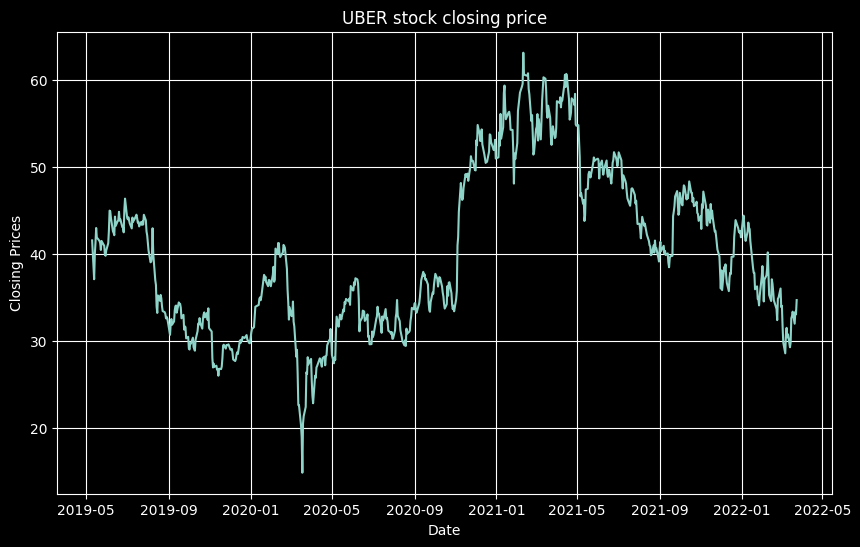

In [ ]:
df_close = stock_data['Close']
plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('UBER stock closing price')

In [ ]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

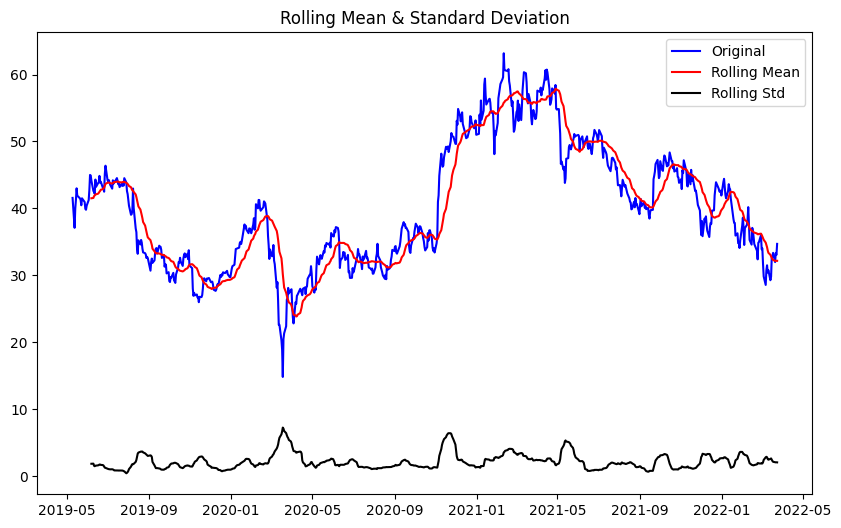

Results of Dickey-Fuller Test:
Test Statistic                  -2.044689
p-value                          0.267329
#Lags Used                       2.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


In [ ]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

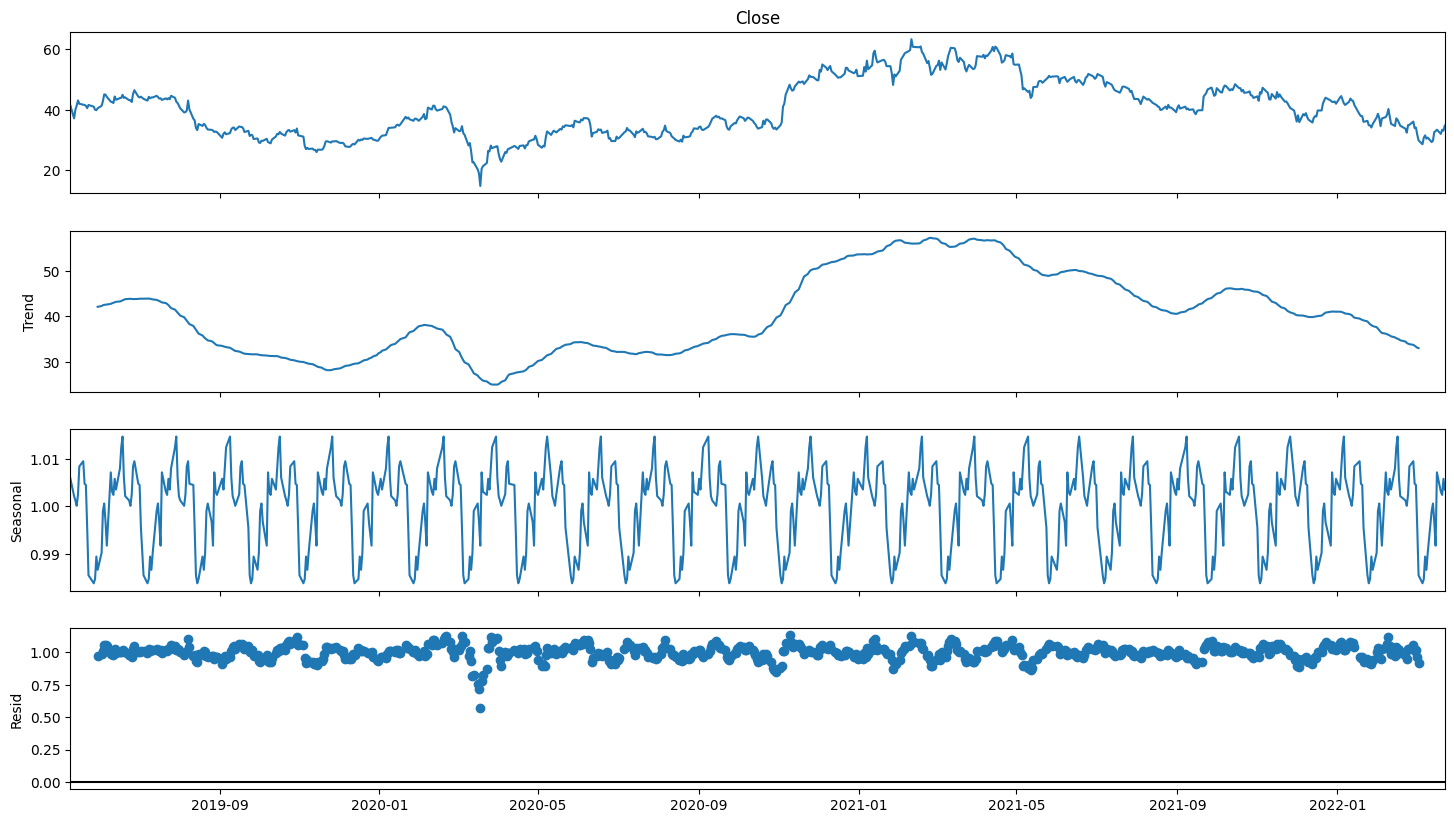

In [ ]:
plt.style.use('default')
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

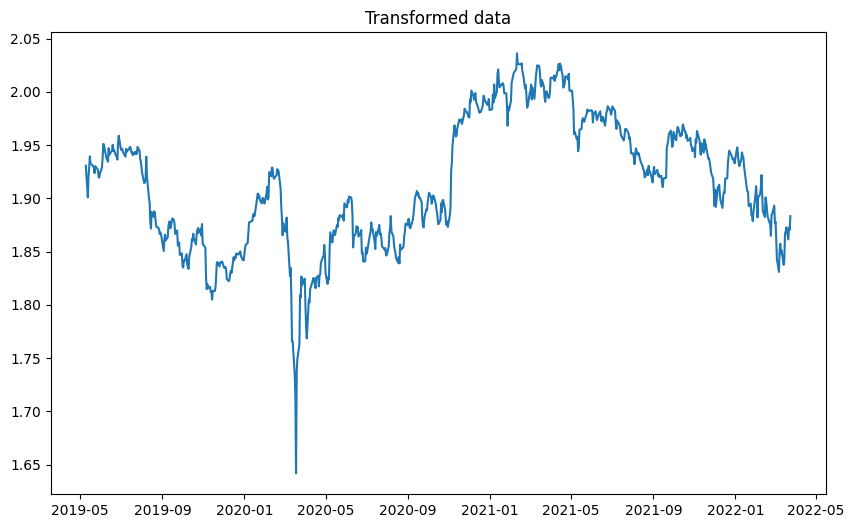

In [ ]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

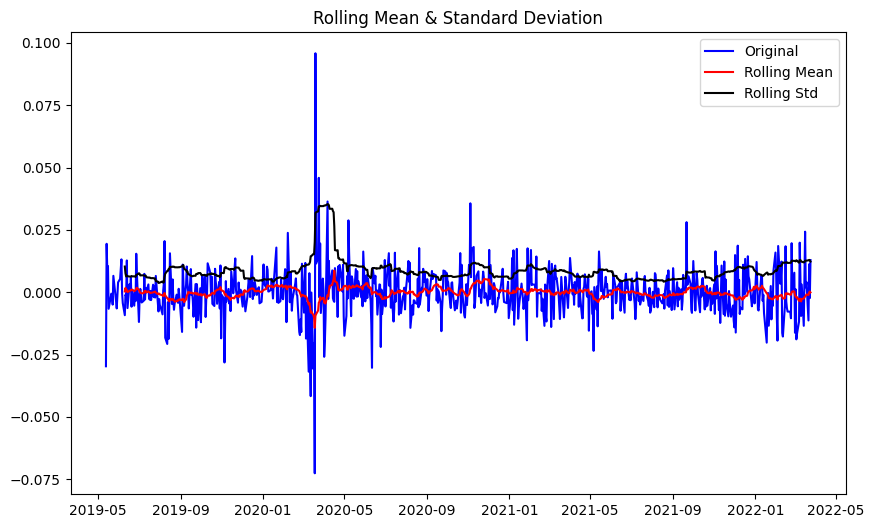

Results of Dickey-Fuller Test:
Test Statistic                -7.517646e+00
p-value                        3.865103e-11
#Lags Used                     1.100000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


In [ ]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [ ]:
def preprocess_lstm(sequence, n_steps, n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [ ]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [ ]:
test_days = 365 # testing data is for one year

X_train, y_train = X[:-test_days], y[:-test_days] # takes all data except the last 365 entries
X_test, y_test = X[-test_days:], y[-test_days:] # takes the last 365 entries from the dataset for testing features

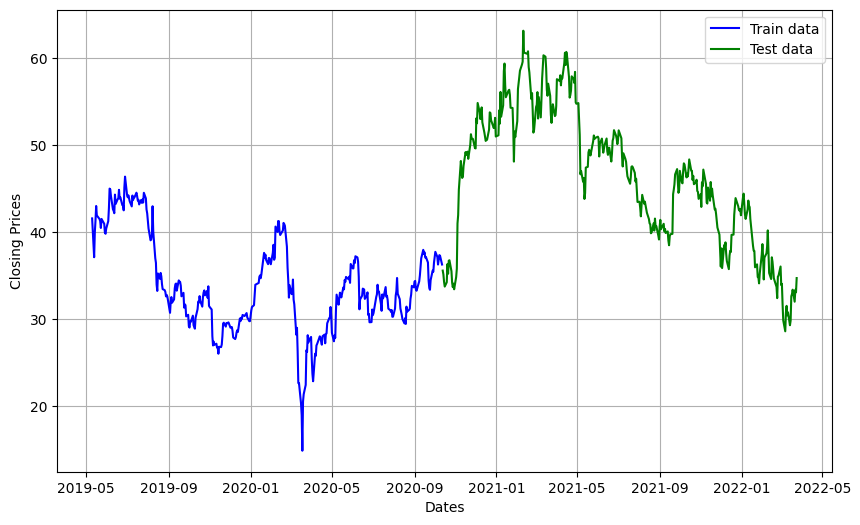

In [ ]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [ ]:
def vanilla_LSTM(nb_days, n_features):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [ ]:
model = vanilla_LSTM(nb_days, n_features)
model.summary()
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.9355e-04 - mean_absolute_error: 0.0091
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4240e-04 - mean_absolute_error: 0.0079
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4703e-04 - mean_absolute_error: 0.0076
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1229e-04 - mean_absolute_error: 0.0071
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3275e-04 - mean_absolute_error: 0.0076
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1827e-04 - mean_absolute_error: 0.0070
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7067e-04 - mean_absolute_error: 0.0079
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2210e-04 - mean_absolute_error: 0.0076
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2676e-04 - mean_absolute_error: 0.0074
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5436e-04 - mean_absolute_error: 0.0081

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.8040e-05 - mean_absolute_error: 0.0063
Test MSE: 6.906879571033642e-05
Test MAE: 0.00641704723238945


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


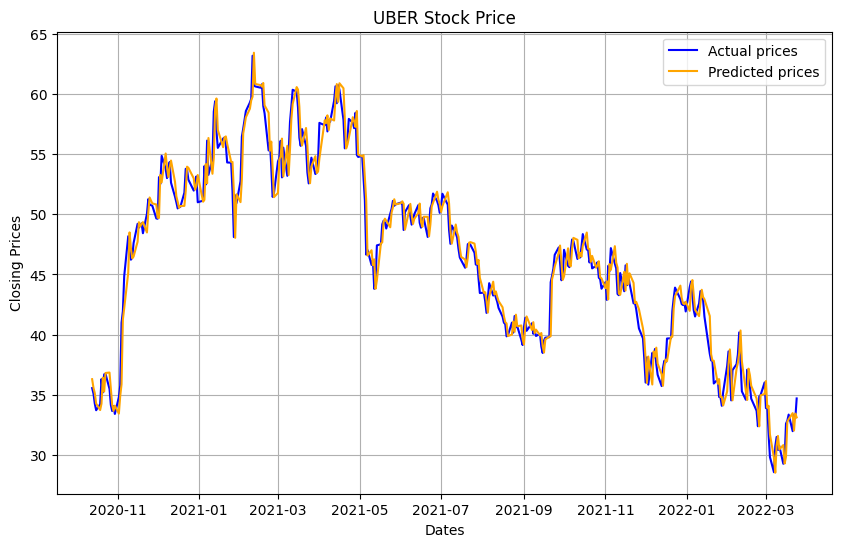

In [ ]:
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

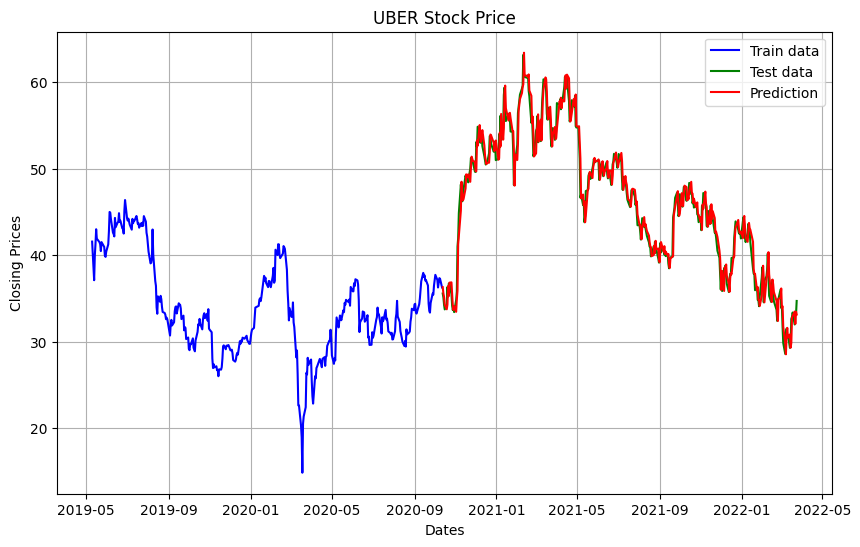

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'red', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

In [ ]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

In [ ]:
n_steps_out = 10

nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)

In [ ]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [ ]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [ ]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 1.6270e-04 - mean_absolute_error: 0.0080
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6309e-04 - mean_absolute_error: 0.0079
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.5590e-04 - mean_absolute_error: 0.0078
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5905e-04 - mean_absolute_error: 0.0078
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4735e-04 - mean_absolute_error: 0.0076
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4625e-04 - mean_absolute_error: 0.0074
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2869e-04 - mean_absolute_error: 0.0073
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4770e-04 - mean_absolute_error: 0.0076
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6045e-04 - mean_absolute_error: 0.0077
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5770e-04 - mean_absolute_error: 0.0078

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.8530e-05 - mean_absolute_error: 0.0063
Test MSE: 6.957395817153156e-05
Test MAE: 0.006460788194090128


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

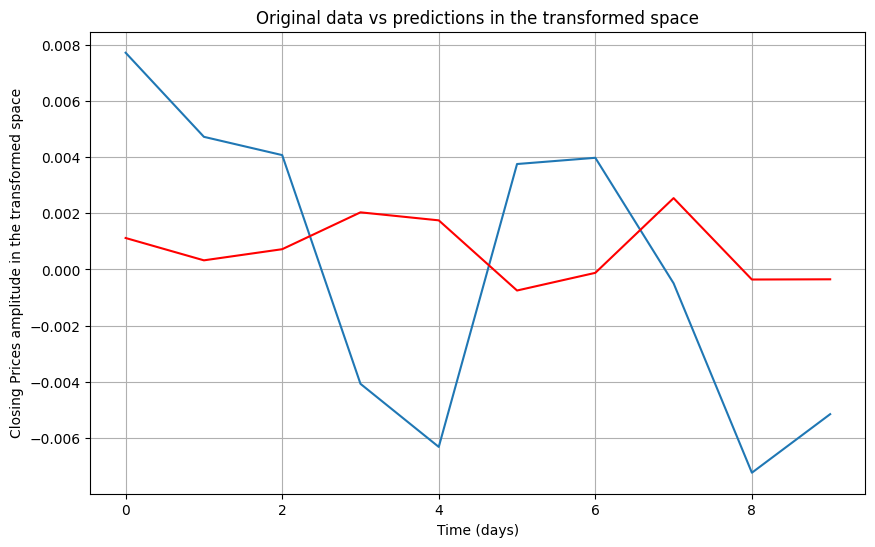

In [ ]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [ ]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2020-10-13    2.008026
2020-10-14    2.008350
2020-10-15    2.009072
2020-10-16    2.011105
2020-10-19    2.012854
2020-10-20    2.012104
2020-10-21    2.011984
2020-10-22    2.014524
2020-10-23    2.014166
2020-10-26    2.013815
dtype: float64


In [ ]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2020-10-13    56.382938
2020-10-14    56.456561
2020-10-15    56.620421
2020-10-16    57.085184
2020-10-19    57.488192
2020-10-20    57.315086
2020-10-21    57.287349
2020-10-22    57.876168
2020-10-23    57.792750
2020-10-26    57.711277
dtype: float64


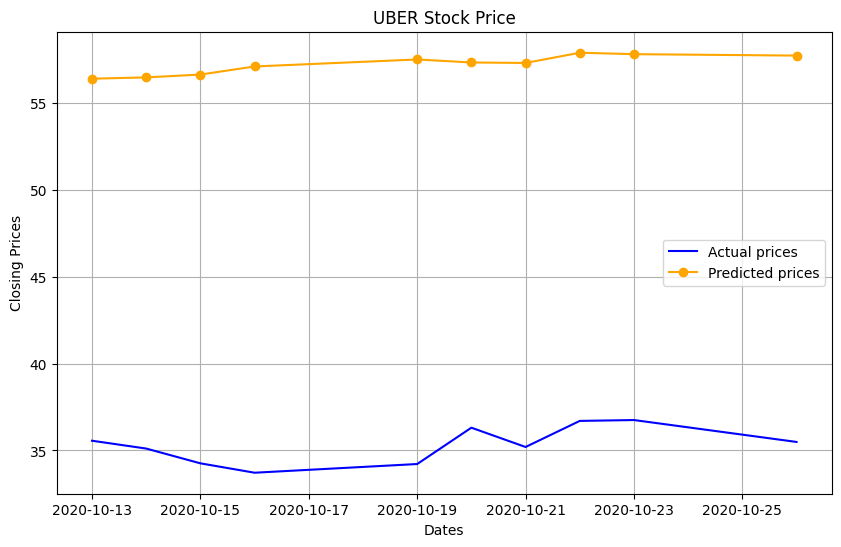

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()